# Optimal LeNet Model and Stability test all_data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

import keras

import tensorflow as tf
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


In [2]:
def set_reproducible():
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

In [3]:
dps1200 = pd.read_csv("dps1200_all.csv")

In [4]:
features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [5]:
def convertToDecade(y:int) -> int: 
    return int(str(y)[:3])

def calculate_sample_weights(y_train):

    decades = [convertToDecade(year) for year in y_train]

    unique_decades, counts = np.unique(decades, return_counts=True)
    total_samples = len(y_train)
    
    weights = {}
    for decade, count in zip(unique_decades, counts):
        weights[decade] = 1 - count/total_samples

    sample_weights = []
    for year in y_train:
        sample_weights.append(weights[convertToDecade(year)])
        
    return np.array(sample_weights)          

In [6]:
def LeNet_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim):
    
    model = keras.Sequential()
    model.add(keras.layers.Input((input_dim, 1)))
    model.add(keras.layers.GaussianNoise(0.0001))

    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))

    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='valid', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DropoutR))

    model.add(keras.layers.Dense(DenseN, activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    

    model.compile(loss=tf.keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=0.004), metrics=['mean_absolute_error'])
    
    return model

# Crossvalidation

Since NN training involves random sampling and weights initialization (in this case), it is usefull to use cross-validation.

In [7]:
## Compute error metrics
def error_metrices(y_true_train, y_predicted_train, y_true_test, y_predicted_test):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_predicted_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_predicted_test))
    R2_train= r2_score(y_true_train, y_predicted_train)
    R2_test= r2_score(y_true_test, y_predicted_test)
    h = tf.keras.losses.Huber()
    hub_train = h(y_true_train, y_predicted_train).numpy()
    hub_test = h(y_true_test, y_predicted_test).numpy()

    print('*********** Benchmark results ***********\n')
    print(f"R2    (Train/Test) = {R2_train:.3f} / {R2_test:.3f}")
    print(f"RMSE  (Train/Test) = {rmse_train:.3f} / {rmse_test:.3f}")
    print(f"Huber (Train/Test) = {hub_train:.3f} / {hub_test:.3f}")

    return (rmse_train, rmse_test, R2_train, R2_test, hub_train, hub_test)

class ModelWithData:
    def __init__(self, model, train_x, train_label, train_predicted, test_x, test_label, test_predicted, score:float, iteration) -> None:
        self.model = model
        self.train_x = train_x
        self.train_label = train_label
        self.train_predicted = train_predicted
        self.test_x = test_x
        self.test_label = test_label
        self.test_predicted = test_predicted
        self.score = score
        self.iteration = iteration

    def isBetter(self, otherScore: float) -> bool:
        return otherScore < 0 or (self.score >= 0 and self.score <= otherScore)

In [8]:

def evaluations_of_models(features, labels, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S):

    x = np.array(features)
    y = np.array(labels)
    input_dim = 1866
    epochs = 800
    
    # generate model
    model = LeNet_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim)

    # Define the number of folds for Cross-Validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores_train = { "rmse": [], "r2": [], "huber": []}
    scores_test = { "rmse": [], "r2": [], "huber": []}


    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5, patience=50, verbose=0, mode='auto', restore_best_weights=True)
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

    bestMwd = ModelWithData(None, 0, 0, 0, 0, 0, 0, -1, 0)
    
    # Iterate through the models
    i = 0
    for train_index, test_index in skf.split(x, y):
        i = i + 1
        print(f'\n\n> Iteration {i}')

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training the CNN-Model on X_train_fold, y_train_fold

        sample_weight=calculate_sample_weights(y_train)
        g = model.fit(x_train, y_train, epochs=epochs, batch_size=45, validation_data=(x_test, y_test), verbose=0, callbacks=[rdlr, monitor], sample_weight=sample_weight)

        # Evaluation of the model on X_test_fold, y_test_fold
        accuracy = model.evaluate(x_test, y_test, verbose=0)
        print(f'Fold Accuracy: {accuracy}')

        # Analyse error metrics

        train_pred = model.predict(x_train, verbose=0)
        test_pred = model.predict(x_test, verbose=0)

        (rmse_train, rmse_test, r2_train, r2_test, huber_train, huber_test) = error_metrices(y_train, train_pred, y_test, test_pred)

        mwd = ModelWithData(g, x_train, y_train, train_pred, x_test, y_test, test_pred, rmse_train, i)

        if mwd.isBetter(bestMwd.score):
            bestMwd = mwd

        scores_train["rmse"].append(rmse_train)
        scores_train["r2"].append(r2_train)
        scores_train["huber"].append(huber_train)

        scores_test["rmse"].append(rmse_test)
        scores_test["r2"].append(r2_test)
        scores_test["huber"].append(huber_test)

    ## clear session 
    tf.keras.backend.clear_session()

    scores_train_mean = {}
    scores_test_mean = {}
    num_model = len(scores_train["rmse"])

    for metric in scores_train.keys():
        scores_train_mean[metric] = np.mean(scores_train[metric])
        scores_test_mean[metric] = np.mean(scores_test[metric])
        print(f'Train: {metric} (mean of {num_model} models)= {scores_train_mean[metric]} \nTest: {metric} (mean of {num_model} models)= {scores_test_mean[metric]}')

    return bestMwd

# Test 1

In [9]:
bestMwd = evaluations_of_models(features, labels, DenseN=422, DropoutR=0.3494832761988253, C1_K=24, C1_S=34, C2_K=52, C2_S=97)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 327: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 456: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 651: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 726: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 772: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 797: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Fold Accuracy: [69.65312957763672, 66.68418884277344]
*********** Benchmark results ***********

R2    (Train/Test) = 0.795 / 0.752
RMSE  (Train/Test) = 90.413 / 97.165
Huber (Train/Test) = 57.065 / 66.192


> Iteration 2

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 78: ReduceLROnPlateau reducing learning rate to

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


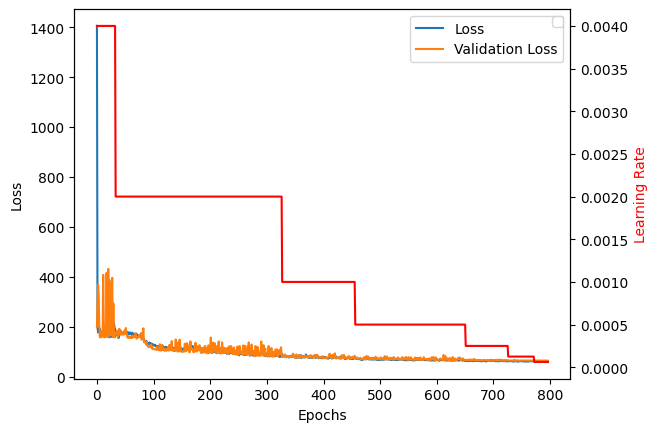

In [11]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

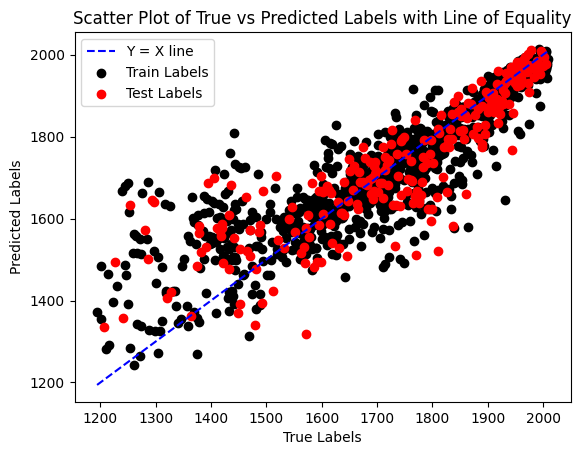

In [12]:
# Create an array of x-values ranging from the minimum to maximum of the data
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()

# Test 2

In [13]:
bestMwd = evaluations_of_models(features, labels, DenseN=422, DropoutR=0.3494832761988253, C1_K=24, C1_S=34, C2_K=52, C2_S=97)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 174: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 371: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 439: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 495: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 557: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 633: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 658: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Fold Accuracy: [70.3902587890625, 64.81295013427734]
*********** Benchmark results ***********

R2    (Train/Test) = 0.819 / 0.767
RMSE  (Train/Test) = 85.073 / 94.180
Huber (Train/Test) = 52.602 / 64.316


> Iteration 2

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Fold Accuracy: [44.90440368652344, 48.52824401855469]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


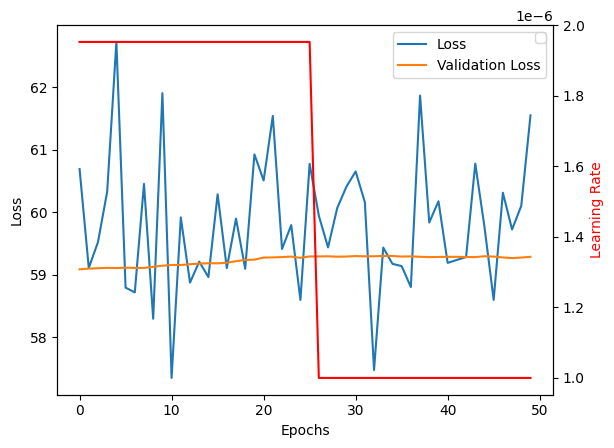

In [14]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

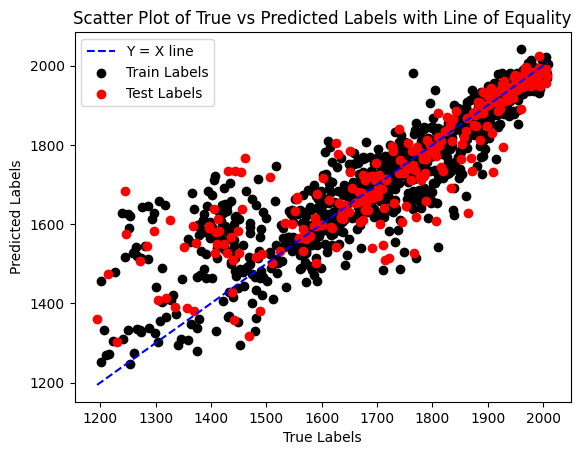

In [15]:
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()

# Test 3

In [16]:
bestMwd = evaluations_of_models(features, labels, DenseN=422, DropoutR=0.3494832761988253, C1_K=24, C1_S=34, C2_K=52, C2_S=97)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 229: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 380: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 424: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 456: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 580: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 633: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 658: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Fold Accuracy: [67.78336334228516, 64.53387451171875]
*********** Benchmark results ***********

R2    (Train/Test) = 0.818 / 0.771
RMSE  (Train/Test) = 85.262 / 93.354
Huber (Train/Test) = 53.569 / 64.041


> Iteration 2

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 57: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Fold Accuracy: [47.32247543334961, 51.37779998779297]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


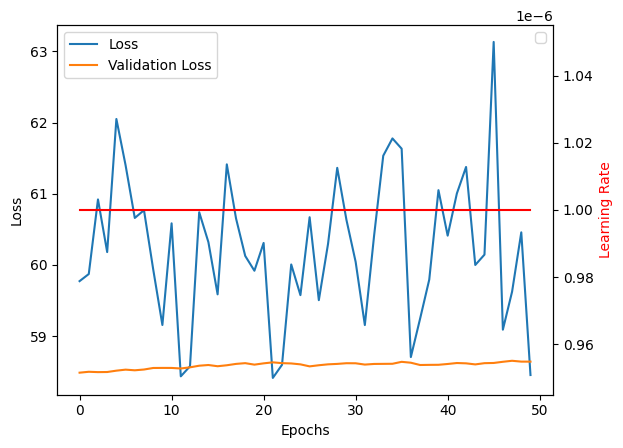

In [17]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

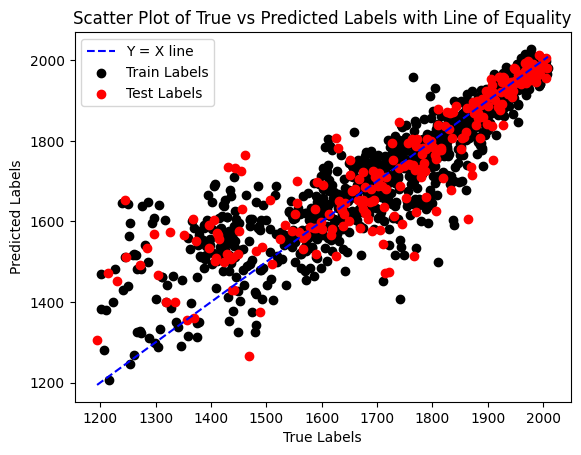

In [18]:
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()

# Test 4

In [19]:
bestMwd = evaluations_of_models(features, labels, DenseN=422, DropoutR=0.3494832761988253, C1_K=24, C1_S=34, C2_K=52, C2_S=97)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 278: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 413: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 528: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 588: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 616: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 641: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Fold Accuracy: [67.4647216796875, 65.04306030273438]
*********** Benchmark results ***********

R2    (Train/Test) = 0.823 / 0.776
RMSE  (Train/Test) = 83.929 / 92.421
Huber (Train/Test) = 53.462 / 64.546


> Iteration 2

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Fold Accuracy: [47.38351821899414, 52.16099166870117]
*********** Benchmark results ***********

R2    (Train/Test) = 0.808 / 0.836
R

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


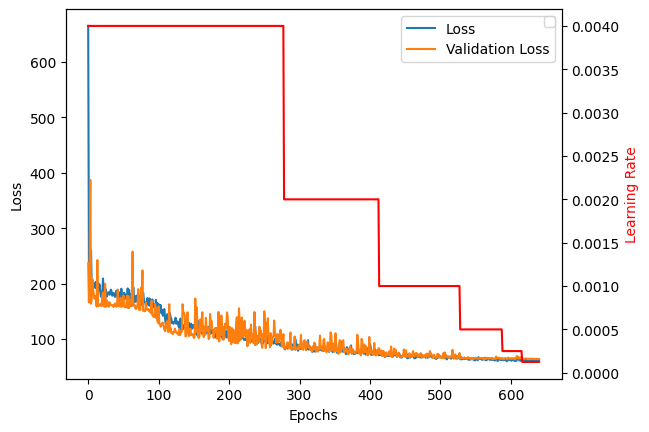

In [20]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

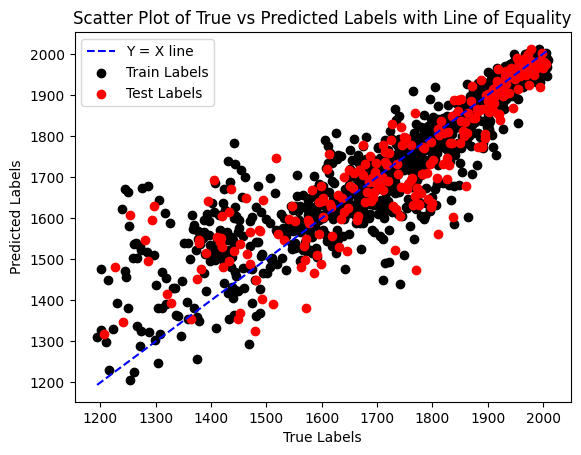

In [21]:
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()

# Test 5

In [22]:
bestMwd = evaluations_of_models(features, labels, DenseN=422, DropoutR=0.3494832761988253, C1_K=24, C1_S=34, C2_K=52, C2_S=97)
print(f"Best model is from iteration {bestMwd.iteration}")

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




> Iteration 1

Epoch 290: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.

Epoch 508: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 690: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 715: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Fold Accuracy: [68.28073120117188, 66.02558135986328]
*********** Benchmark results ***********

R2    (Train/Test) = 0.815 / 0.766
RMSE  (Train/Test) = 85.823 / 94.466
Huber (Train/Test) = 54.291 / 65.529


> Iteration 2

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Fold Accuracy: [47.904579162597656, 52.33640670776367]
*********** Benchmark results ***********

R2    (Train/Test) = 0.806 / 0.827
RMSE  (Train/Test) = 87.149 / 84.323
Huber (Train/Test) = 55.991 / 51.838


> Iteration 3

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.12500014842

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


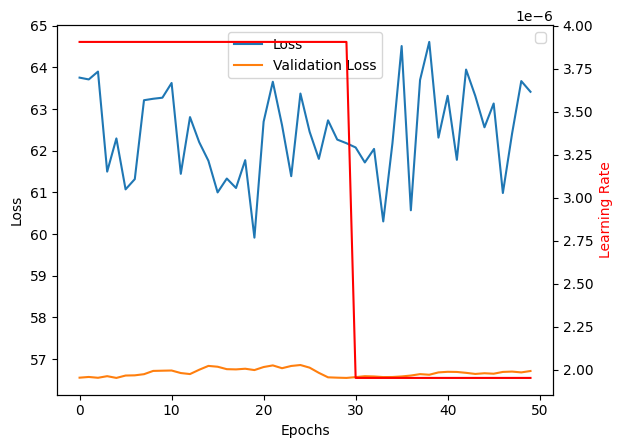

In [23]:
plt.plot(bestMwd.model.history['loss'], label='Loss')
plt.plot(bestMwd.model.history['val_loss'], label='Validation Loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(bestMwd.model.history['learning_rate'], color='r')
ax2.set_ylabel('Learning Rate',color='r')

Eval_of_model = plt.legend()

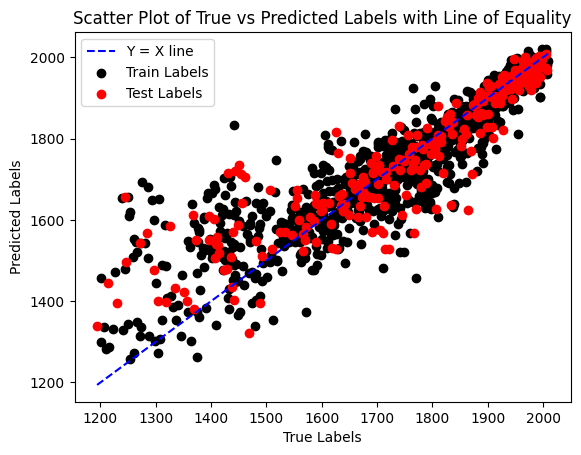

In [24]:
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(bestMwd.train_label, bestMwd.train_predicted, c='k', label='Train Labels')
plt.scatter(bestMwd.test_label, bestMwd.test_predicted, c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()